import matplotlib.pyplot as plt
import seaborn as sns
# ^^^ pyforest auto-imports - don't write above this line
# Imports

What I am working on now is trying to get the aggrigate sum of all the movies ratings into the first iteration of the movie and the average of what that movie is rated based off the sum partially got it done. but for some reason it wont allow the ratings sum to attach to the first iteration of that movieId

In [1]:
import numpy as np
import pandas as pd
# ^^^ pyforest auto-imports - don't write above this line
import pyforest
import warnings
from surprise import SVD,NormalPredictor
from surprise.model_selection import train_test_split
from surprise.dataset import Dataset
from surprise import Reader
from surprise import AlgoBase
from surprise import accuracy
import random
from surprise.model_selection import cross_validate

from surprise.prediction_algorithms.knns import KNNBasic

from surprise.model_selection import GridSearchCV
warnings.filterwarnings("ignore")

# Package Installs

In [2]:
# !pip install -U scikit-surprise==1.1.0

# Functions

In [3]:
class RandomRating(AlgoBase):
    def __init__(self, p = .5):
        self.p = p
        AlgoBase.__init__(self)
        
    def estimate(self,u,i):
        return np.random.binomial(n = 5,p = self.p,size = 1)[0]
    
    

In [2]:
np.random.seed(0)

def get_data():
    movies = pd.read_csv('ml-latest-small/movies.csv')
    links = pd.read_csv('ml-latest-small/links.csv')
    ratings = pd.read_csv('ml-latest-small/ratings.csv')
    tags = pd.read_csv('ml-latest-small/tags.csv')
    return movies,links,ratings,tags

def clean_data(movies,links,ratings):
    ratings.drop('timestamp',axis = 1, inplace = True)
    
    
        
    
    df1 = pd.merge(movies,links,on ='movieId')
    
    df = pd.merge(df1,ratings,on = 'movieId',how = 'inner')
    df['release year'] = df['title'].str[-6:]
    df['title'] = [x[:-6] for x in df['title']]
    df['release year'] = df['release year'].str.extract(r'\((.*)\)')
    df['release year'] = df['release year'].fillna(0).astype(int)
    df['genres'] = df['genres'].str.split('|').astype(str)  
    df.drop(['imdbId','tmdbId'],axis = 1,inplace = True)
#     df.drop_duplicates(subset = 'movieId',keep = 'first',inplace = True)
    return df


def predict_evaluate(recsys,dataset,name = 'Algorithm'):
    scores = cross_validate(
    recsys, dataset, measures = ['RMSE','MAE'], cv = 4)
    print('Testset Avg MAE: {:.2f} Avg RMSE : {:.2f} [{}]'.format(scores['test_mae'].mean(), scores['test_rmse'].mean(), name))
    
    
def user_interest():
#     movies['title'] = [x[:-6] for x in movies['title']]
    new_user = input('Are you a new user?')
    if new_user == 'yes':
        user = (df['userId'].values.max() +1)
    else:
        user = (df['userId'].values.max())
    genre_input = input('Give me a genre: ')
    genre_based = df[df.genres.str.contains(genre_input.title())]
    titles = list(genre_based['title'])
    title = []
    [title.append(x) for x in titles if x not in title]
    
    movies = pd.DataFrame(columns = df.columns)
    for i in range (1,11):
        
        x = random.choice(titles)
        y = float(input('what would you rate the movie ' + x))
        movies2 = df[(df.title.values == x)]
        movies2.drop_duplicates(subset = 'title',keep = 'first',inplace = True)
        movies2['rating'] = y
        movies2['userId'] = user
       
        movies = movies.append(movies2)
#         df.groupby('movieId')['rating'].count().reset_index().sort_values('movieId',ascending = False)

        
#     ratings count,average rating

    return movies,user

# Pull data from Functions and view the data

In [3]:
movies,links,ratings,tags = get_data()
df = clean_data(movies,links,ratings)


In [6]:
print('movies head')
display(movies.head())
print('links head')
display(links.head())
print('ratings head')
display(ratings.head())
print('tags head')
display(tags.head())



movies head


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


links head


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


ratings head


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


tags head


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [7]:
df.head()

,movieId,title,genres,userId,rating,release year
0,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",1,4.0,1995
1,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",5,4.0,1995
2,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",7,4.5,1995
3,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",15,2.5,1995
4,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",17,4.5,1995


In [8]:
# rating_count = ratings_counts(df)

In [9]:
# rating_count.head()

# Checking graphs of beginning data

what we are going to do is check the movie dataset for any type of "weird" noise or off setting data. First what we will do is check the datasets ratings for any type of rating malfunction and outliers to the data. After that we will check for some of the highest users who have rated the data. and then we will end with looking at the high and low end to the movies ratings.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<BarContainer object of 19 artists>

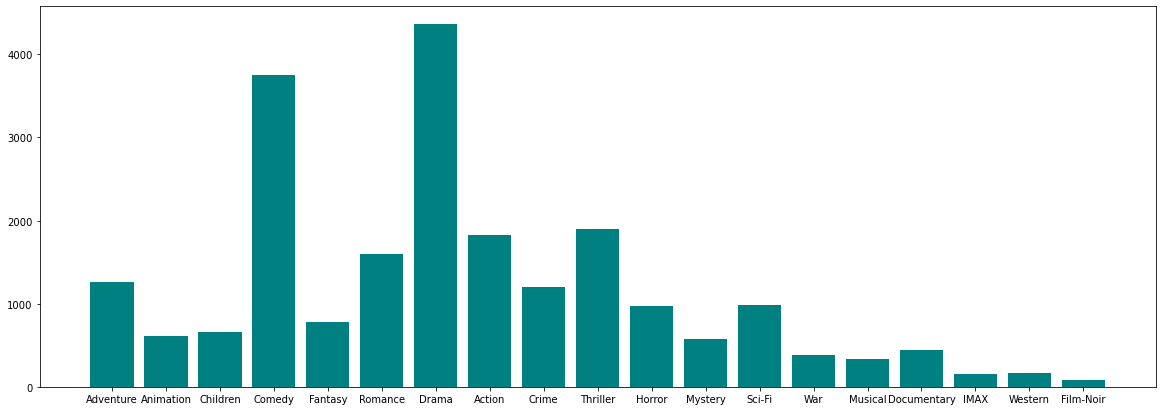

In [10]:
plt.figure(figsize = (20,7))
genlist = movies['genres'].apply(lambda x :str(x).split('|'))
genre_count = {}
for genlist_movie in genlist:
    for genre in genlist_movie:
        if(genre_count.get(genre,False)):
            genre_count[genre] = genre_count[genre] +1
        else:
            genre_count[genre] = 1
genre_count.pop('(no genres listed)')
plt.bar(genre_count.keys(),genre_count.values(),color = 'teal')

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='rating', ylabel='Density'>

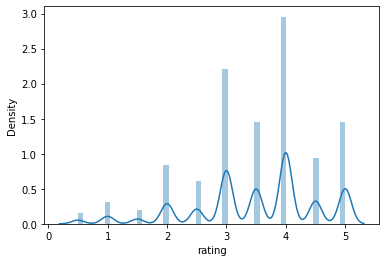

In [11]:
sns.distplot(df['rating'])

<AxesSubplot:xlabel='userId'>

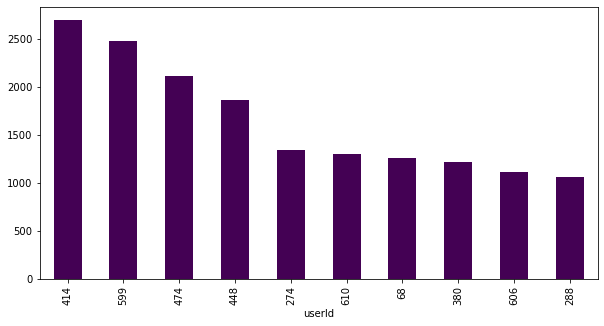

In [12]:
ratings_by_users = df.groupby('userId').agg([np.size,np.mean])
ratings_by_users['rating']['size'].sort_values(ascending = False).head(10).plot(kind ='bar',figsize = (10,5),cmap = 'viridis')

There is no surprise that the high end of the movie ratings only go to 5, so lets take a look at the movies lower end to see what movies are the lowest rated. To make it easier for us we will be looking at the titles of the movies

<AxesSubplot:ylabel='title'>

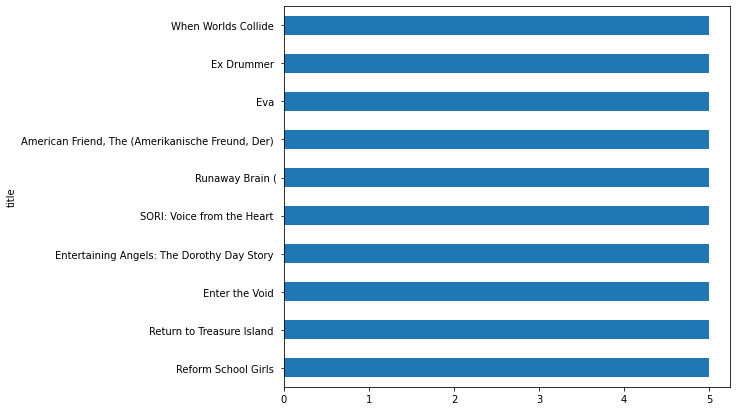

In [13]:
ratings_by_movieId = df.groupby('title').agg([np.mean],np.size)

ratings_by_movieId['rating']['mean'].sort_values(ascending = False).head(10).plot(kind = 'barh',figsize = (8,7))

<AxesSubplot:ylabel='title'>

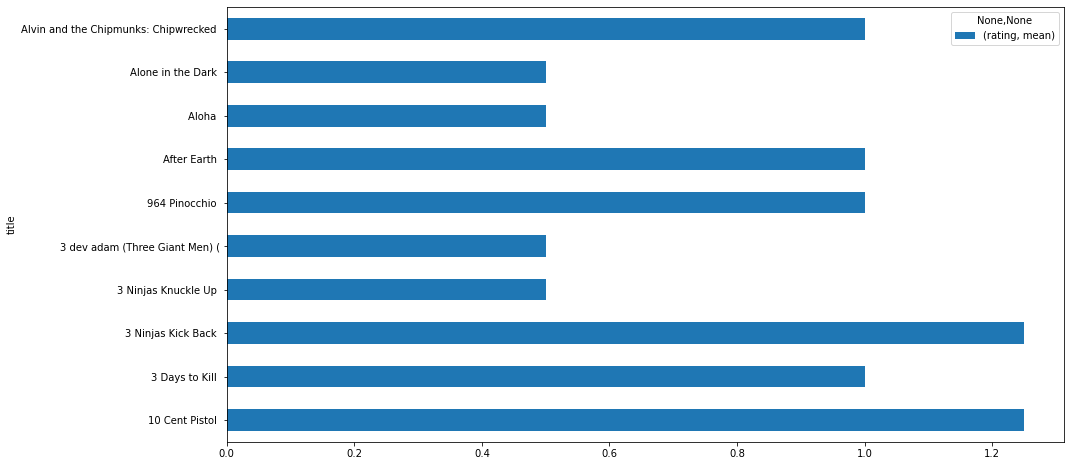

In [14]:
ratings_by_movieId.drop(['release year','movieId','userId'],axis = 1,inplace = True)
low_rated = ratings_by_movieId['rating']['mean'] <1.5
lower = ratings_by_movieId[low_rated]
lower.head(10).plot(kind = 'barh', figsize = (15,8))

In [15]:
higher_than_3 = df[df['rating']>= 3.0]
higher_than_3.head()

,movieId,title,genres,userId,rating,release year
0,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",1,4.0,1995
1,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",5,4.0,1995
2,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",7,4.5,1995
4,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",17,4.5,1995
5,1,Toy Story,"['Adventure', 'Animation', 'Children', 'Comedy...",18,3.5,1995


In [16]:
new_ratings = higher_than_3.drop(['title','genres','release year'],axis = 1)

# Fixing the cold start problem
The cold start problem is where a new user comes in and we have nothing to recommend to them. This will somewhat solve that problem by asking them to rate a few movies at random and setting it into the dataframe and allowing us to be able to perform some sort of customizing based off of that data. 


In [17]:
user_movies,user = user_interest()
print("")
print('User movie interest Dataframe')
display(user_movies.head())

print('')
print('Checking dataframe for additions')
df.tail()


Are you a new user?yes
Give me a genre: Action
what would you rate the movie Appleseed (Appurushîdo) 2
what would you rate the movie Last Boy Scout, The 3
what would you rate the movie Austin Powers: The Spy Who Shagged Me 5
what would you rate the movie Harry Potter and the Deathly Hallows: Part 2 5
what would you rate the movie Rush 4
what would you rate the movie Gone in 60 Seconds 3.5
what would you rate the movie Maze Runner, The 4
what would you rate the movie First Knight 2
what would you rate the movie Tequila Sunrise 1
what would you rate the movie Conquest of the Planet of the Apes 2.5

User movie interest Dataframe


,movieId,title,genres,userId,rating,release year
79095,31184,Appleseed (Appurushîdo),"['Action', 'Animation', 'Fantasy', 'Sci-Fi']",611,2.0,2004
73303,7007,"Last Boy Scout, The","['Action', 'Comedy', 'Crime', 'Drama', 'Thrill...",611,3.0,1991
46335,2683,Austin Powers: The Spy Who Shagged Me,"['Action', 'Adventure', 'Comedy']",611,5.0,1999
93082,88125,Harry Potter and the Deathly Hallows: Part 2,"['Action', 'Adventure', 'Drama', 'Fantasy', 'M...",611,5.0,2011
75664,8158,Rush,"['Crime', 'Drama']",611,4.0,1991



Checking dataframe for additions


,movieId,title,genres,userId,rating,release year
100831,193581,Black Butler: Book of the Atlantic,"['Action', 'Animation', 'Comedy', 'Fantasy']",184,4.0,2017
100832,193583,No Game No Life: Zero,"['Animation', 'Comedy', 'Fantasy']",184,3.5,2017
100833,193585,Flint,['Drama'],184,3.5,2017
100834,193587,Bungo Stray Dogs: Dead Apple,"['Action', 'Animation']",184,3.5,2018
100835,193609,Andrew Dice Clay: Dice Rules,['Comedy'],331,4.0,1991


In [41]:
user_movies[user_movies['userId'] == 611]

,movieId,userId,rating
79095,31184,611,2.0
73303,7007,611,3.0
46335,2683,611,5.0
93082,88125,611,5.0
75664,8158,611,4.0
56621,3717,611,3.5
97468,114180,611,4.0
4949,168,611,2.0
48321,2802,611,1.0
44704,2532,611,2.5


In [19]:
counts = df.groupby('movieId')['rating'].count().reset_index().sort_values('movieId',ascending = False)
averages = df.groupby('movieId')['rating'].mean().reset_index().sort_values('movieId',ascending = False)

In [20]:
user_movies.head()

,movieId,title,genres,userId,rating,release year
79095,31184,Appleseed (Appurushîdo),"['Action', 'Animation', 'Fantasy', 'Sci-Fi']",611,2.0,2004
73303,7007,"Last Boy Scout, The","['Action', 'Comedy', 'Crime', 'Drama', 'Thrill...",611,3.0,1991
46335,2683,Austin Powers: The Spy Who Shagged Me,"['Action', 'Adventure', 'Comedy']",611,5.0,1999
93082,88125,Harry Potter and the Deathly Hallows: Part 2,"['Action', 'Adventure', 'Drama', 'Fantasy', 'M...",611,5.0,2011
75664,8158,Rush,"['Crime', 'Drama']",611,4.0,1991


In [24]:
user_movies = user_movies.drop(['title','genres','release year'],axis = 1)

# to_ratings = to_ratings.drop('Recommended Score',axis = 1)
# new_ratings = new_ratings.append(to_ratings)
# new_ratings.tail(10)
ratings = ratings.append(user_movies)
ratings.tail()

,userId,movieId,rating
56621,611,3717,3.5
97468,611,114180,4.0
4949,611,168,2.0
48321,611,2802,1.0
44704,611,2532,2.5


In [25]:
# ratings = ratings.drop(['title','genres','release year'],axis = 1)

In [26]:
ratings.tail()

,userId,movieId,rating
56621,611,3717,3.5
97468,611,114180,4.0
4949,611,168,2.0
48321,611,2802,1.0
44704,611,2532,2.5


# Setting the vectorizer objects

In [29]:
ratings_pivot = ratings.pivot(index = 'movieId',columns = 'userId', values='rating').reset_index(drop = True)
ratings_pivot.fillna(0, inplace = True)
ratings_pivot.head()

userId,1,2,3,4,5,6,7,8,9,10,...,602,603,604,605,606,607,608,609,610,611
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0,0.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Setting reader object from surprise for recommending system

In [30]:
reader = Reader(rating_scale= (1,6))
dataset = Dataset.load_from_df(ratings,reader)


# Finding the best model and training on that model

In [31]:
trainset,testset = train_test_split(dataset,test_size = .25,random_state = 5)

In [32]:
recsys = RandomRating(p=.168)
predict_evaluate(recsys,dataset,'RandomRating')

Testset Avg MAE: 2.31 Avg RMSE : 2.54 [RandomRating]


In [33]:

recsys = KNNBasic()
predict_evaluate(recsys,dataset,'KNNBasic')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Testset Avg MAE: 0.73 Avg RMSE : 0.95 [KNNBasic]


In [34]:
sim_options = {'name':'cosine', 'user_based': True, 'k':40,'verbose':True}

recsys = KNNBasic(k=20,sim_options = sim_options)
# predict_evaluate(recsys,dataset,'KNNBasic')
recsys.fit(trainset)
# best model

Computing the cosine similarity matrix...
Done computing similarity matrix.


Running grid search on a portion of the dataset

In [35]:
# param_grid = {'sim_options':{'name':['cosine','pearson'],
#                             },
#              'k':[5,10,20,40],
#              'verbose':[True]}
# dataset_subset = Dataset.load_from_df(ratings.sample(frac = .25,random_state = 0),reader)
# gscv = GridSearchCV(KNNBasic,param_grid,measures =['rmse','mae'],cv=4,n_jobs =-1)
# gscv.fit(dataset)

# print('Best MAE: ',gscv.best_score['mae'].round(2))
# print('Best RMSE: ',gscv.best_score['rmse'].round(2))
# print('Best Params: ',gscv.best_params['rmse'])

# Peer to Peer
here we are taking the model and predicting the estimation score of what the model would recommend based off of the given movieId

In [38]:
user1 =random.choice(df['userId'])
df['Recommended Score'] = df['userId'].apply(lambda x: recsys.predict(user,x).est)
# df = df.drop(['userId','rating','ratings count','average rating'],axis = 1)
recmov = df.sort_values(by=['Recommended Score'],ascending = False)
recmov.drop_duplicates(subset = 'title',keep = 'first',inplace = True)
recommend = recmov[recmov['Recommended Score']>3]
recommend.head(5)

,movieId,title,genres,userId,rating,release year,Recommended Score
86989,58559,"Dark Knight, The","['Action', 'Crime', 'Drama', 'IMAX']",496,4.5,2008,5.0
99586,148626,"Big Short, The",['Drama'],495,5.0,2015,5.0
90737,74458,Shutter Island,"['Drama', 'Mystery', 'Thriller']",495,4.5,2010,5.0
69300,5957,Two Weeks Notice,"['Comedy', 'Romance']",495,4.0,2002,5.0
64042,4886,"Monsters, Inc.","['Adventure', 'Animation', 'Children', 'Comedy...",148,3.0,2001,5.0


In [39]:
ratings[ratings['userId'] == user1]

,userId,movieId,rating
15041,96,1,5.0
15042,96,34,5.0
15043,96,50,5.0
15044,96,110,5.0
15045,96,150,5.0
...,...,...,...
15114,96,3555,3.0
15115,96,3578,4.0
15116,96,3633,2.0
15117,96,3635,2.0


In [ ]:
# ratings_pivot.head()
# display(ratings['userId'] == 0)
# ratings['userId'].tail()
user_movies.head()

# Item to item
This is where we will be taking the title of a movie and giving recommendations based off the title.

In [43]:
algorithm = SVD(n_factors = 35, n_epochs = 25, lr_all = 0.008, reg_all = 0.08)

In [44]:
trainset, testset = train_test_split(dataset, test_size=0.25,random_state = 5)
predictions = algorithm.fit(trainset).test(testset)
accuracy.rmse(predictions)

RMSE: 0.8589


0.8589327433354834

In [45]:
def get_Iu(userid):
    """
    args: 
    uid: the id of the user
    returns:
    the number of items rated by the user
    """

    try:
        return len(trainset.ur[trainset.to_inner_uid(userid)])
    except ValueError: # user was not part of the trainset
        return 0
def get_Ui(movieid):
    """
    args:
    iid: the raw id of the item
    returns:
    the number of users that have rated the item.
    """
    try:
        return len(trainset.ir[trainset.to_inner_iid(movieid)])
    except ValueError:
        return 0


In [46]:
df_predictions = pd.DataFrame(predictions, columns=['userid', 'movieid', 'ratingByUser', 'estimated_rating', 'details'])
df_predictions['Iu'] = df_predictions.userid.apply(get_Iu)
df_predictions['Ui'] = df_predictions.movieid.apply(get_Ui)
df_predictions['err'] = abs(df_predictions.estimated_rating - df_predictions.ratingByUser)

In [47]:
df_predictions.head()

,userid,movieid,ratingByUser,estimated_rating,details,Iu,Ui,err
0,334,7361,4.0,3.798587,{'was_impossible': False},116,95,0.201413
1,509,68554,3.0,3.016627,{'was_impossible': False},368,12,0.016627
2,74,55820,4.5,4.297890,{'was_impossible': False},137,49,0.202110
3,584,34,3.0,4.486694,{'was_impossible': False},65,95,1.486694
4,380,3440,1.0,2.539854,{'was_impossible': False},915,9,1.539854


In [48]:
best_predictions = df_predictions.sort_values(by='err')[:10]
worst_predictions = df_predictions.sort_values(by='err')[-10:]

In [49]:
best_predictions.head()

,userid,movieid,ratingByUser,estimated_rating,details,Iu,Ui,err
20091,214,648,3.0,3.000050,{'was_impossible': False},15,130,0.000050
12946,177,2959,4.0,4.000055,{'was_impossible': False},683,171,0.000055
1525,586,6156,4.0,3.999785,{'was_impossible': False},150,12,0.000215
10396,453,104,4.0,3.999706,{'was_impossible': False},238,75,0.000294
23737,6,575,3.0,2.999695,{'was_impossible': False},237,14,0.000305


In [50]:
worst_predictions.head()

,userid,movieid,ratingByUser,estimated_rating,details,Iu,Ui,err
12173,522,106100,0.5,4.252154,{'was_impossible': False},155,12,3.752154
24717,594,6975,0.5,4.292884,{'was_impossible': False},179,2,3.792884
17825,413,1246,1.0,4.823629,{'was_impossible': False},37,70,3.823629
22147,413,1198,1.0,4.929282,{'was_impossible': False},37,155,3.929282
9689,125,4973,0.5,4.438784,{'was_impossible': False},264,82,3.938784


In [51]:
trainset = dataset.build_full_trainset()   #Build on entire data set
algo = SVD(n_factors = 35, n_epochs = 25, lr_all = 0.008, reg_all = 0.08)
algo.fit(trainset)

# Predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

#Predicting the ratings for testset
predictions = algo.test(testset)

In [52]:
def get_all_predictions(predictions):
    from collections import defaultdict
    # First map the predictions to each user.
    top_n = defaultdict(list)    
    for userid, movieid, true_r, est, _ in predictions:
        top_n[userid].append((movieid, est))

    # Then sort the predictions for each user
    for userid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)

    return top_n

In [53]:
all_pred = get_all_predictions(predictions)
n =10
for userid, user_ratings in all_pred.items():
    user_ratings.sort(key=lambda x: x[1], reverse=True)
    all_pred[userid] = user_ratings[:n]
tmp = pd.DataFrame.from_dict(all_pred)
tmp_transpose = tmp.transpose()


In [54]:
def get_predictions(user_id):
    results = tmp_transpose.loc[user_id]
    return results

In [55]:
user_id=user
results = get_predictions(user_id)
results

0    (177593, 4.665846885589994)
1        (750, 4.65932254892134)
2      (898, 4.6428604096917745)
3    (106642, 4.597457190258482)
4     (3266, 4.5469735470359085)
5      (2239, 4.535874454725564)
6      (1208, 4.530252395703357)
7      (1104, 4.528667942285488)
8       (318, 4.512330980526442)
9      (1136, 4.511559667679045)
Name: 96, dtype: object

In [56]:
recommended_movie_ids=[]
for x in range(0, n):
    recommended_movie_ids.append(results[x][0])

recommended_movie_ids

[177593, 750, 898, 106642, 3266, 2239, 1208, 1104, 318, 1136]

In [57]:
# movies[movies['movieId'] == ]

In [58]:
recommended_movies = movies[movies['movieId'].isin(recommended_movie_ids)]
recommended_movies

,movieId,title,genres
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
680,898,"Philadelphia Story, The (1940)",Comedy|Drama|Romance
841,1104,"Streetcar Named Desire, A (1951)",Drama
863,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
909,1208,Apocalypse Now (1979),Action|Drama|War
1664,2239,Swept Away (Travolti da un insolito destino ne...,Comedy|Drama
2453,3266,Man Bites Dog (C'est arrivé près de chez vous)...,Comedy|Crime|Drama|Thriller
8301,106642,"Day of the Doctor, The (2013)",Adventure|Drama|Sci-Fi
9618,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama


In [59]:
temp = ratings[ratings['userId'] == user].sort_values("rating", ascending = False)
temp.head()

,userId,movieId,rating
15041,96,1,5.0
15092,96,2058,5.0
15074,96,1210,5.0
15073,96,1200,5.0
15072,96,1198,5.0


In [60]:
history_movie_ids = temp['movieId']
user_history = movies[movies['movieId'].isin(history_movie_ids)]


In [61]:
user_history[:n]

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
32,34,Babe (1995),Children|Drama
46,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
97,110,Braveheart (1995),Action|Drama|War
123,150,Apollo 13 (1995),Adventure|Drama|IMAX
163,193,Showgirls (1995),Drama
224,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
234,272,"Madness of King George, The (1994)",Comedy|Drama
257,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
259,299,Priest (1994),Drama


In [62]:
recommended_movies

,movieId,title,genres
277,318,"Shawshank Redemption, The (1994)",Crime|Drama
602,750,Dr. Strangelove or: How I Learned to Stop Worr...,Comedy|War
680,898,"Philadelphia Story, The (1940)",Comedy|Drama|Romance
841,1104,"Streetcar Named Desire, A (1951)",Drama
863,1136,Monty Python and the Holy Grail (1975),Adventure|Comedy|Fantasy
909,1208,Apocalypse Now (1979),Action|Drama|War
1664,2239,Swept Away (Travolti da un insolito destino ne...,Comedy|Drama
2453,3266,Man Bites Dog (C'est arrivé près de chez vous)...,Comedy|Crime|Drama|Thriller
8301,106642,"Day of the Doctor, The (2013)",Adventure|Drama|Sci-Fi
9618,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama
